### Import relevant libraries

In [102]:
from semopy import Model, calc_stats, semplot
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
import seaborn as sns
from semopy.inspector import inspect

### Import the dataset

In [103]:
df = pd.read_csv("Welzijnsmonitor2025_scaled_normalised_UTF8.csv", sep=";")

### Creating the model

In [104]:
model_desc = """
# measurement model

Wellbeing =~ Bevl_1 + Bevl_2 + Bevl_3 + Cogn_Eng1_5 + Cogn_Eng1_6 + Cogn_Eng2_2 + Cogn_Eng2_3 + Cogn_Eng2_8 + Mot_Stress_1 + Mot_Stress_4
Interventions =~ Bekendgebruik_4 + Bekendgebruik_5 + Bekendgebruik_6 + Bekendgebruik_7
Negative_Outcomes =~ StopInt + Vertr
Positive_Outcomes =~ Cijfer_huidig_1 + Stopint2
Stressors =~ Onnodige_stress_1 + Onnodige_stress_2 + Onnodige_stress_3 + Onnodige_stress_4 + Onnodige_stress_5 + Onnodige_stress_6 + Onnodige_stress_7
Response_to_Stress =~ Burn1_1 + Burn1_2 + Burn1_3 + Burn1_4 + Depr_1 + Depr_2 + Depr_3 + Depr_4 + Depr_5 + Depr_6 + Depr_7 + Depr_8 + Mot_Stress_2

Participation =~ Partici1_1 + Partici1_2 + Partici1_3 + Partici1_4
Behavior =~ Cogn_Eng1_1 + Cogn_Eng1_2 + Cogn_Eng1_4 + Cogn_Eng2_1 + Cogn_Eng2_4 + Cogn_Eng2_5 + Cogn_Eng2_6 + Cogn_Eng2_7

# Covariances (two-headed arrows in the diagram)
Response_to_Stress ~~ Wellbeing
Stressors ~~ Participation

# Regressions
Participation ~ Interventions + Behavior
Response_to_Stress ~ Stressors + Participation
Wellbeing ~ Stressors + Participation

Negative_Outcomes ~ Response_to_Stress + Wellbeing
Positive_Outcomes ~ Wellbeing + Response_to_Stress
"""

In [105]:
model = Model(model_desc)
model.fit(df)

df_imputed = model.predict(df)
latent_scores = model.predict_factors(df_imputed)

# Export the model with the new latent variables and their descriptive statistics

In [106]:
latent_scores.to_csv("latent_variable_scores.csv", index=False)
latent_scores.describe()

,Behavior,Interventions,Negative_Outcomes,Participation,Positive_Outcomes,Response_to_Stress,Stressors,Wellbeing
count,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03
mean,-6.109164e-17,9.398713e-18,-3.806479e-16,-7.518971e-17,1.089663e-16,-9.398713e-17,-2.349678e-17,3.642001e-16
std,2.375003e-01,4.575140e-01,5.780481e-01,6.590184e-01,1.459652e-01,6.337077e-01,6.276793e-01,7.844467e-01
min,-9.706302e-01,-3.367347e-01,-1.414331e+00,-1.521802e+00,-5.815286e-01,-1.635988e+00,-2.045794e+00,-3.130097e+00
25%,-1.549538e-01,-2.798585e-01,-4.046906e-01,-4.750479e-01,-7.598466e-02,-4.685484e-01,-4.395817e-01,-4.044377e-01
50%,8.070546e-03,-2.329853e-01,-9.972328e-02,-9.698401e-02,2.289580e-02,-5.679423e-02,3.858683e-02,1.232407e-01
75%,1.511840e-01,6.730007e-02,3.092885e-01,4.076989e-01,9.627012e-02,4.160191e-01,4.616093e-01,5.165007e-01
max,7.376698e-01,2.323687e+00,2.383500e+00,2.253422e+00,3.629514e-01,2.366696e+00,1.516480e+00,1.954614e+00


In [107]:
latents = set(model.vars['latent'])
observeds = set(model.vars['observed'])

est = model.inspect(std_est=True)

# Factor loadings = observed ~ latent
loadings = est[
    (est['op'] == '~') &
    (est['lval'].isin(observeds)) &
    (est['rval'].isin(latents))
]

print("Factor loadings:")
display(loadings)

Factor loadings:


,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
10,Bevl_1,~,Wellbeing,1.000000,0.653169,-,-,-
11,Bevl_2,~,Wellbeing,1.157229,0.795321,0.043836,26.399077,0.0
12,Bevl_3,~,Wellbeing,1.085004,0.681303,0.046644,23.261247,0.0
13,Cogn_Eng1_5,~,Wellbeing,1.209691,0.716517,0.049857,24.263144,0.0
14,Cogn_Eng1_6,~,Wellbeing,0.964582,0.579548,0.047699,20.222322,0.0
15,Cogn_Eng2_2,~,Wellbeing,0.769214,0.414237,0.0517,14.878415,0.0
16,Cogn_Eng2_3,~,Wellbeing,0.645232,0.369645,0.048291,13.361311,0.0
17,Cogn_Eng2_8,~,Wellbeing,0.742016,0.451899,0.045984,16.13633,0.0
18,Mot_Stress_1,~,Wellbeing,1.164873,0.757056,0.045894,25.381724,0.0
19,Mot_Stress_4,~,Wellbeing,1.231179,0.836590,0.044863,27.442854,0.0


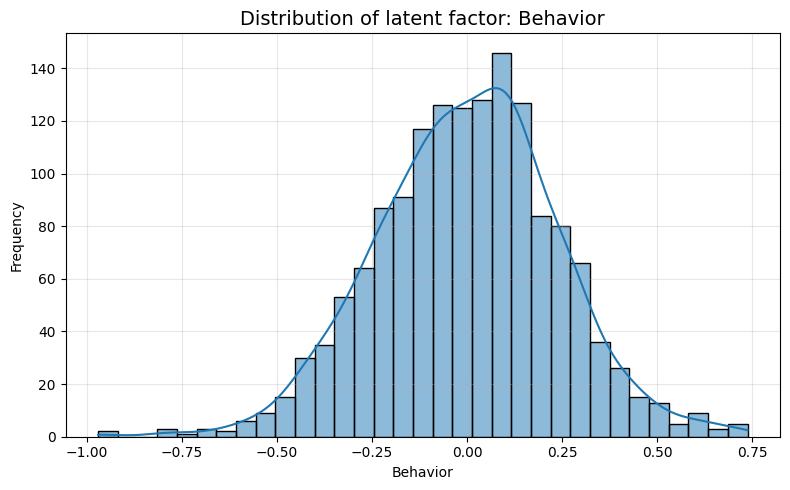

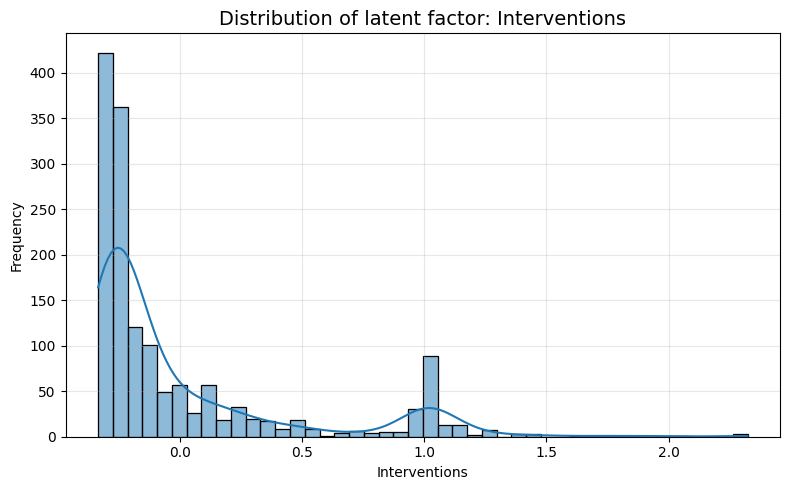

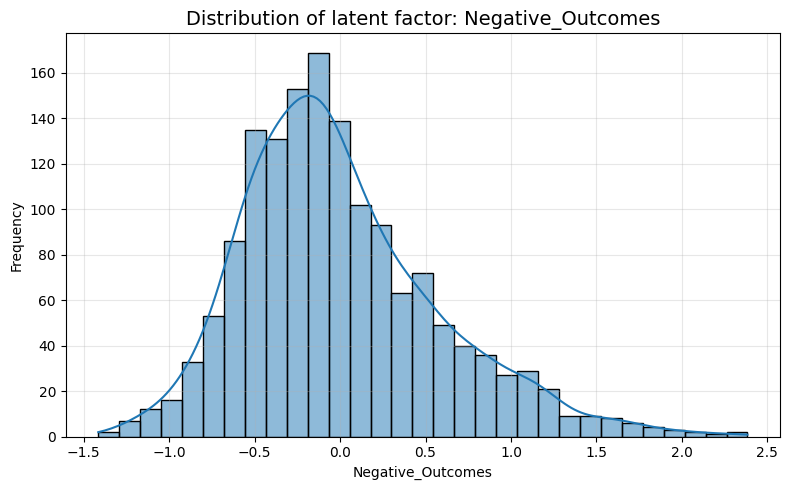

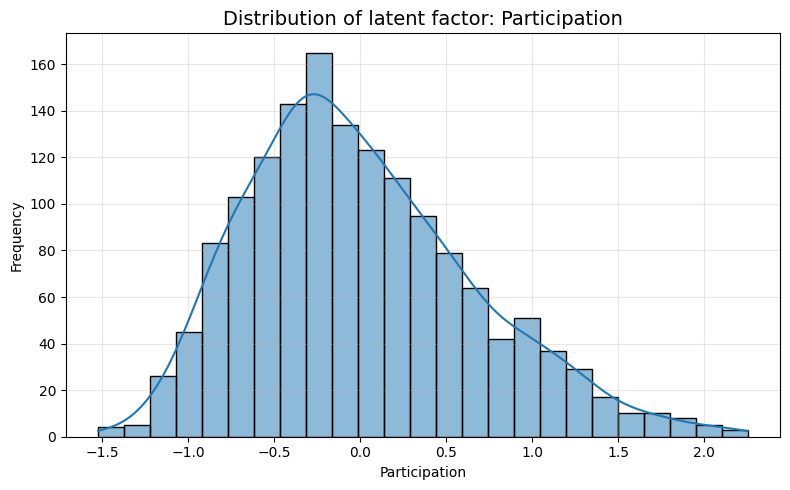

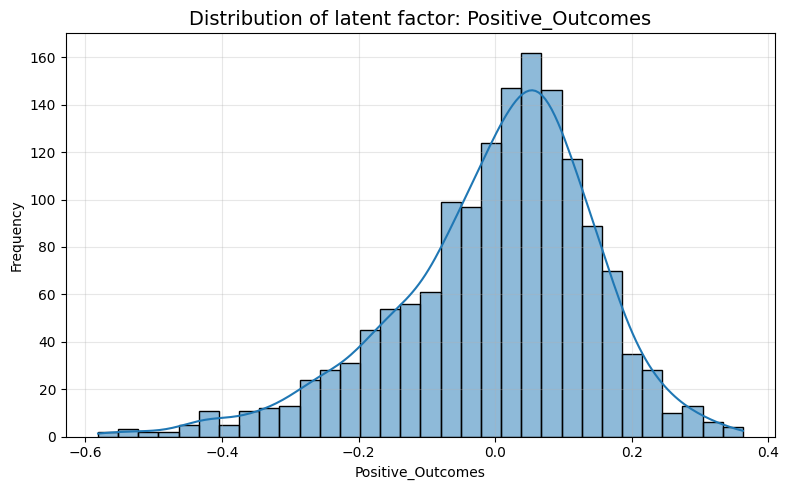

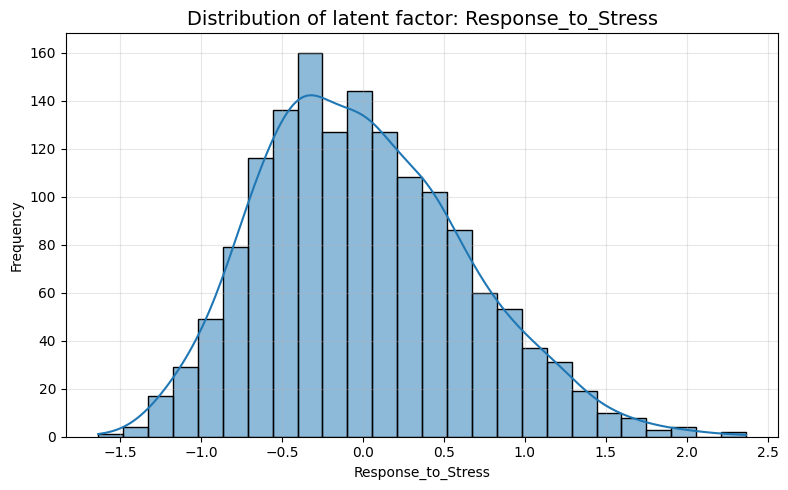

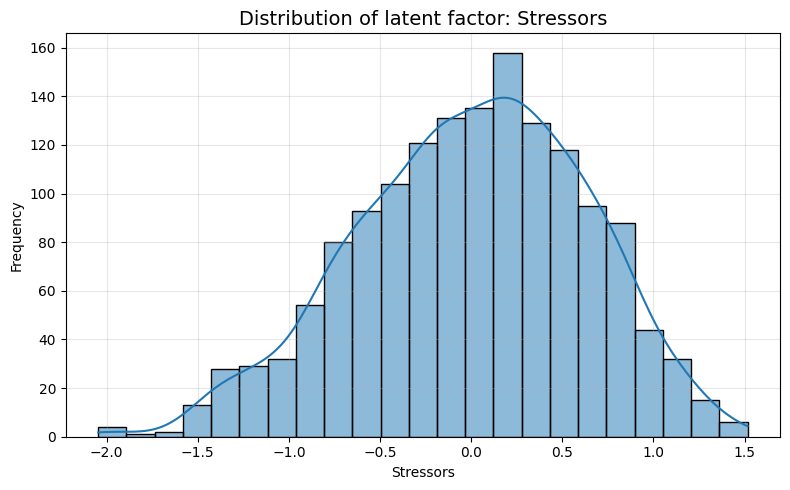

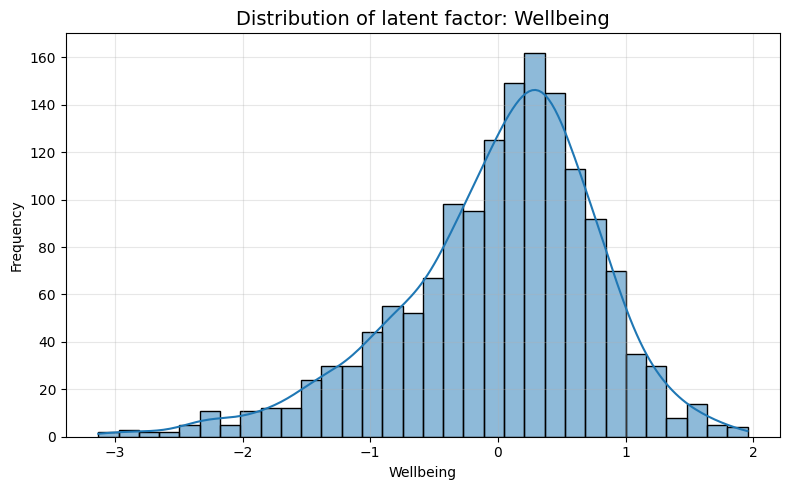

In [108]:
# Plot histogram for each latent variable
for col in latent_scores.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(latent_scores[col], kde=True)
    plt.title(f"Distribution of latent factor: {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Correlation matrix

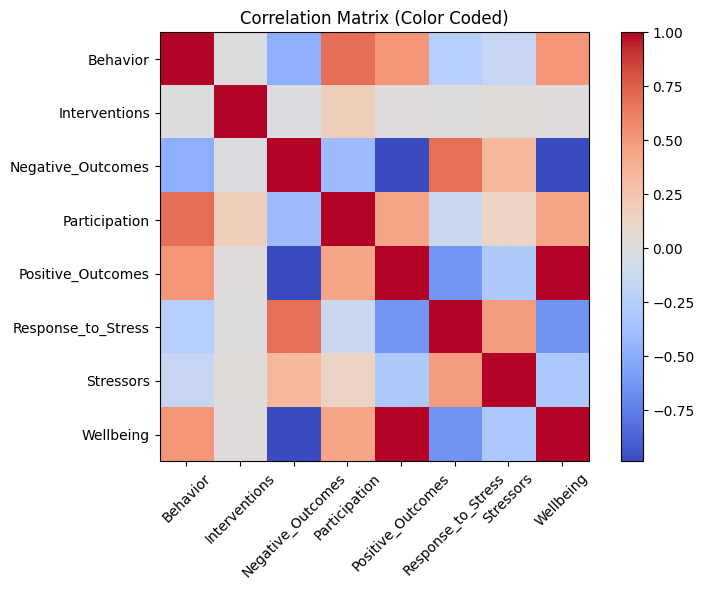

In [109]:
corr_matrix = latent_scores.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, interpolation='nearest', cmap='coolwarm')
plt.title("Correlation Matrix (Color Coded)")
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.tight_layout()
plt.show()

# print(corr_matrix)

### Calculate fit indices

In [110]:
stats = calc_stats(model)

print("=== Model Fit Statistics ===")
print(stats.T)

=== Model Fit Statistics ===
                      Value
DoF             1160.000000
DoF Baseline    1225.000000
chi2            9471.171580
chi2 p-value       0.000000
chi2 Baseline  29605.386373
CFI                0.707151
GFI                0.680086
AGFI               0.662160
NFI                0.680086
TLI                0.690741
RMSEA              0.068860
AIC              217.471995
BIC              829.408679
LogLik             6.264002


### Create and save the path diagram

In [111]:
g = semplot(model, "pd3.png")

### Extract model coefficients

In [112]:
coefficients = model.inspect()
coefficients.to_csv("model_coefficients.csv")
coefficients.to_excel("model_coefficients.xlsx")

In [113]:
def pretty_sem_latent_explicit(model):
    df = model.inspect().copy()

    # List of latent relationships as (lval, op, rval)
    wanted = [
        # covariances
        ("Response_to_Stress", "~~", "Wellbeing"),
        ("Stressors", "~~", "Behavior"),

        # regressions
        ("Participation", "~",  "Intervention"),
        ("Participation", "~",  "Behavior"),
        ("Response_to_Stress", "~",  "Stressors"),
        ("Response_to_Stress", "~",  "Participation"),
        ("Wellbeing",          "~",  "Stressors"),
        ("Wellbeing",          "~",  "Participation"),
        ("Negative_Outcomes",  "~",  "Response_to_Stress"),
        ("Negative_Outcomes",  "~",  "Wellbeing"),
        ("Positive_Outcomes",  "~",  "Response_to_Stress"),
        ("Positive_Outcomes",  "~",  "Wellbeing"),
    ]

    wanted_df = pd.DataFrame(wanted, columns=["lval", "op", "rval"])

    # Inner join to keep only those rows
    df = df.merge(wanted_df, on=["lval", "op", "rval"], how="inner")

    # Label type + from/to
    df["Type"] = df["op"].map({"~": "Regression", "~~": "Covariance"})
    df["From"] = df["lval"]
    df["To"]   = df["rval"]

    # Clean p-values (handles "<0.001")
    p_clean = df["p-value"].astype(str).str.replace("<", "", regex=False)
    df["p_value"] = pd.to_numeric(p_clean, errors="coerce")

    # Significance stars
    def stars(p):
        if pd.isna(p): return ""
        if p < 0.001: return "***"
        if p < 0.01:  return "**"
        if p < 0.05:  return "*"
        if p < 0.10:  return "."
        return ""

    df["Sig"] = df["p_value"].apply(stars)

    # Numeric & rounded
    for col in ["Estimate", "Std. Err", "z-value", "p_value"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").round(4)

    # Final table
    nice = df[[
        "Type", "From", "To",
        "Estimate", "Std. Err", "z-value", "p_value", "Sig"
    ]].copy()

    nice = nice.rename(columns={"Std. Err": "Std_Err"})

    return nice

latent_table = pretty_sem_latent_explicit(model)
latent_table   # last line in the cell → shows a nice table

,Type,From,To,Estimate,Std_Err,z-value,p_value,Sig
0,Regression,Participation,Behavior,1.5045,0.1518,9.9094,0.0000,***
1,Regression,Response_to_Stress,Stressors,0.4230,0.0341,12.4045,0.0000,***
2,Regression,Response_to_Stress,Participation,-0.0882,0.0251,-3.5082,0.0005,***
3,Regression,Wellbeing,Stressors,-0.2558,0.0268,-9.5284,0.0000,***
4,Regression,Wellbeing,Participation,0.2967,0.0257,11.5307,0.0000,***
5,Regression,Negative_Outcomes,Response_to_Stress,0.0821,0.0186,4.4079,0.0000,***
6,Regression,Negative_Outcomes,Wellbeing,-0.2814,0.0230,-12.2078,0.0000,***
7,Regression,Positive_Outcomes,Wellbeing,0.1867,0.0263,7.1073,0.0000,***
8,Regression,Positive_Outcomes,Response_to_Stress,0.0012,0.0158,0.0755,0.9398,
9,Covariance,Response_to_Stress,Wellbeing,-0.1318,0.0110,-12.0129,0.0000,***
